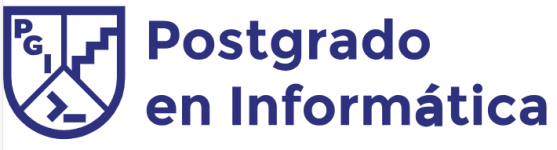

**Universidad Mayor de San Andrés** <br>
**Postgrado en Informática** <br>
**Maestría en Inteligencia Artificial para la Transformación de Negocios** <br>
**Módulo: Modelamiento de Datos I** <br>
**Docente:** MSc. Edwin Salcedo<br>
**Estudiantes:**
<ul>
  <li>Enrique miranda</li>
  <li>Daniel Herrera</li>
  <li>Ivan Davalos</li>
  <li>Roy Sillerico</li>
  <li>Rumy Mamani</li>


# **Proyecto Final**

La tuberculosis (TB), causada por *Mycobacterium tuberculosis*, sigue siendo una de las principales causas de mortalidad a nivel mundial, particularmente en regiones con acceso limitado a servicios médicos especializados. La interpretación manual de radiografías de tórax, herramienta clave para el diagnóstico inicial, presenta desafíos inherentes: dependencia de radiólogos expertos, variabilidad en la calidad de las imágenes y la subjetividad en el análisis.

Este proyecto propone el desarrollo de un sistema automatizado basado en redes neuronales convolucionales (CNN), capaz de clasificar imágenes de tórax como normales o con indicios de tuberculosis. El objetivo es proporcionar una herramienta de apoyo al diagnóstico que sea rápida, precisa y escalable, permitiendo su uso en contextos con escasez de recursos humanos especializados.

### 📂 Dataset

Se utilizará el *Dataset of Tuberculosis Chest X-rays Images*, que contiene imágenes de radiografías de tórax clasificadas en dos categorías: "Normal Chest X-rays" y "TB Chest X-rays". El conjunto de datos ha sido preprocesado para estandarizar las imágenes a un tamaño de 256x256 píxeles y convertirlas a escala de grises.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip -qn '/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/Dataset_of_Tuberculosis_Chest_X-rays_Images.zip' -d '/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/' > /dev/null

In [38]:
# Importamos librerias
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

In [39]:
# Inicalizamos los valores necesarios para las images y valores necesarios
normaldir = '/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays'
tbdir = '/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays'
images = []
labels = []
imagesize = 256

In [40]:
print("Number of TB images:", len(os.listdir(tbdir)))
print("Number of Normal images:", len(os.listdir(normaldir)))

Number of TB images: 2494
Number of Normal images: 514


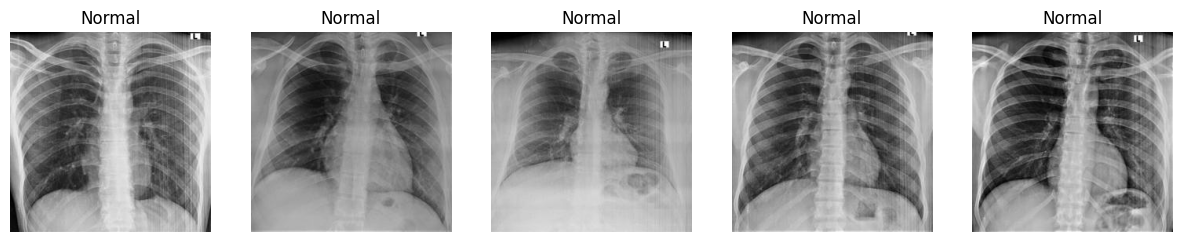

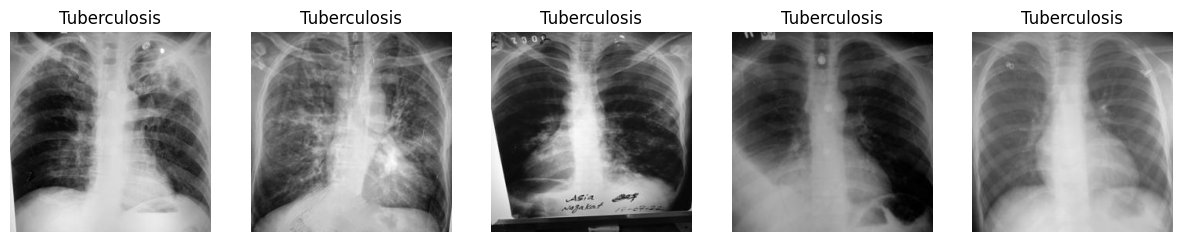

In [41]:
def show_examples(class_path, title, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15,5))
    for i, fname in enumerate(os.listdir(class_path)[:n]):
        img = cv2.imread(os.path.join(class_path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title)
    plt.show()

show_examples(normaldir, "Normal")
show_examples(tbdir, "Tuberculosis")

In [42]:
#Almacenar todos los directorios de imágenes en la matriz 'imágenes' y corresponderlos a 1 para imágenes TB o 0 para imágenes normales.
for x in os.listdir(normaldir):
  imagedir = os.path.join(normaldir, x)
  image = cv2.imread(imagedir, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (imagesize, imagesize))
  images.append(image)
  labels.append(0)

for y in os.listdir(tbdir):
  imagedir = os.path.join(tbdir, y)
  image = cv2.imread(imagedir, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (imagesize, imagesize))
  images.append(image)
  labels.append(1)

In [43]:
#Conversión a matrices NumPy, ya que tienen más funciones que las listas normales
images = np.array(images)
labels = np.array(labels)

#Dividimos las imágenes y las etiquetas en conjuntos de entrenamiento y prueba, y luego normalizar los valores dentro de ellos para lograr eficiencia computacional (de escala 0-255 a escala 0-1)
imagetrain, imagetest, labeltrain, labeltest = train_test_split(images, labels, test_size=0.3, random_state=42)
imagetrain = (imagetrain.astype('float32'))/255
imagetest = (imagetest.astype('float32'))/255

In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#Aplanamiento de la matriz de imágenes a 2D (convirtiéndola en [2940 imágenes] x [todos los píxeles de la imagen en una sola matriz unidimensional]) para que sea adecuada para el sobremuestreo SMOTE
imagetrain = imagetrain.reshape(imagetrain.shape[0], (imagesize*imagesize))

#Realizamos un sobremuestreo
smote = SMOTE(random_state=42)
imagetrain, labeltrain = smote.fit_resample(imagetrain, labeltrain)

#Aplanamos las imágenes para usarlas en una red neuronal convolucional (4914 imágenes de tamaño 256x256, con 1 canal de color (escala de grises, en comparación con RGB con 3 canales de color))
imagetrain = imagetrain.reshape(-1, imagesize, imagesize, 1)
print(imagetrain.shape)

(3516, 256, 256, 1)


In [45]:
#Clases equilibradas: cantidades iguales de cada etiqueta
print(np.unique(labeltrain, return_counts=True))

(array([0, 1]), array([1758, 1758]))


In [46]:
#Importamos las librerias necesarias para la construccion del modelo
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import seaborn as sns

In [47]:
#El modelo CNN tiene 3 capas convolucionales, cada una seguida de una agrupación para resumir las características encontradas por la capa,
#comenzando con 16 y multiplicando por 2 cada vez para lograr eficiencia computacional, ya que los bits están estructurados en potencias de 2. Se utilizan filtros 3x3 y activación ReLU.

cnn = keras.Sequential(
    [
    #Input layer, same shape as all the images (256x256x1):
    keras.Input(shape=(imagesize, imagesize, 1)),

    #1era capa convolucional
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    #2da capa convolucional
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    #3era capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    #Capa de aplanamiento para las capas densas:
    Flatten(),

    #1era capa densa después de las capas convolucionales:
    Dense(64, activation='relu'),

    #Capa Dropout que tiene una alta tasa de abandono para evitar el sobreajuste en un conjunto de datos relativamente grande
    Dropout(0.5),

    #Capa de salida que comprime cada imagen a 0 o 1 con activación sigmoidea
    Dense(1, activation='sigmoid')
    ]
)

In [48]:
#Compilación del modelo con los parámetros más adecuados para la tarea en cuestión:
cnn.compile(
    loss='binary_crossentropy', #El mejor para clsificacion binaria
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #Buen LR inicial para un conjunto de datos de este tamaño
    metrics=['accuracy'], #BUscamos precision
)

In [49]:
#Ajustando el modelo, con la función de llamada ReduceLROnPlateau añadida para reducir la tasa de aprendizaje y aumentar la precisión gradualmente cuando esta se estabilice (va en la dirección incorrecta).
#Hacer esto con patience=1, lo que significa que se ejecutará incluso si se estabilice durante una época, ya que solo se utilizan 5 épocas.
#Factor=0.1 significa que cada vez que se reduce la tasa de aprendizaje, se reduce por un factor de 0.1; tampoco bajará de 0.00001.
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = cnn.fit(imagetrain, labeltrain, validation_data=(imagetest, labeltest), batch_size=16, epochs=5, verbose=2, callbacks = [reduce_lr])

Epoch 1/5
220/220 - 10s - 44ms/step - accuracy: 0.9261 - loss: 0.1623 - val_accuracy: 0.9900 - val_loss: 0.0298 - learning_rate: 1.0000e-03
Epoch 2/5
220/220 - 4s - 16ms/step - accuracy: 0.9883 - loss: 0.0503 - val_accuracy: 0.9834 - val_loss: 0.0526 - learning_rate: 1.0000e-03
Epoch 3/5
220/220 - 4s - 16ms/step - accuracy: 0.9892 - loss: 0.0388 - val_accuracy: 0.9646 - val_loss: 0.1040 - learning_rate: 1.0000e-03
Epoch 4/5
220/220 - 4s - 17ms/step - accuracy: 0.9923 - loss: 0.0289 - val_accuracy: 0.9967 - val_loss: 0.0108 - learning_rate: 1.0000e-03
Epoch 5/5
220/220 - 4s - 16ms/step - accuracy: 0.9926 - loss: 0.0216 - val_accuracy: 0.9900 - val_loss: 0.0421 - learning_rate: 1.0000e-03


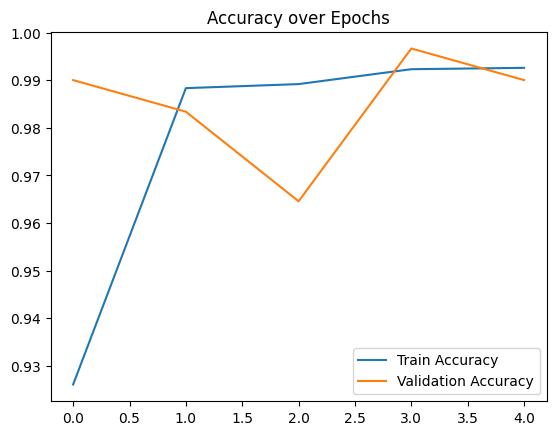

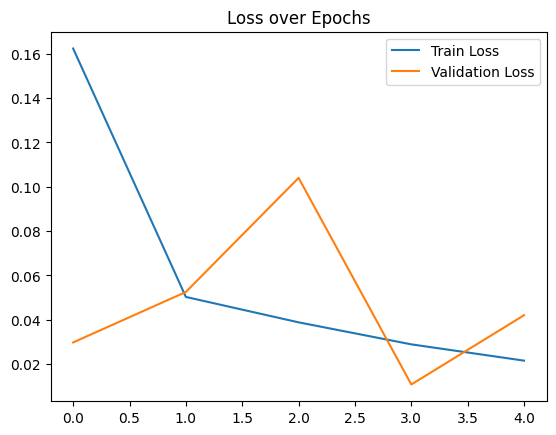

In [50]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [51]:
#Evaluación de los datos con múltiples tipos de métricas
print('TESTING DATA:')
cnn.evaluate(imagetest, labeltest, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = cnn.predict(imagetest, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(labeltest, predicted_labels))

TESTING DATA:
29/29 - 1s - 19ms/step - accuracy: 0.9900 - loss: 0.0421
ADVANCED TESTING METRICS:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       167
           1       1.00      0.99      0.99       736

    accuracy                           0.99       903
   macro avg       0.97      0.99      0.98       903
weighted avg       0.99      0.99      0.99       903



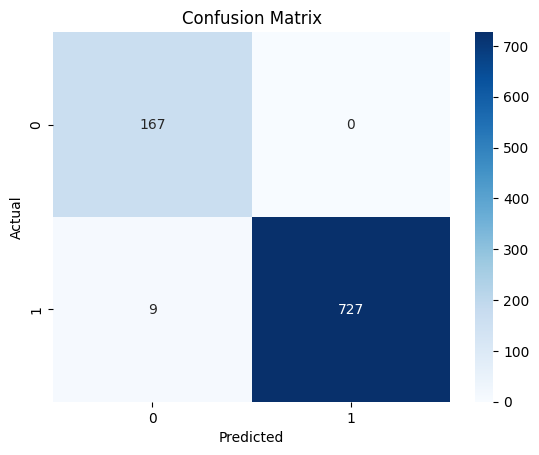

In [52]:
# Matriz de confusion
conf_matrix = confusion_matrix(labeltest, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
cnn.save("/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/tuberculosis_model-99.h5")

In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

# Cargando el modelo
model = load_model("/content/drive/MyDrive/CURSOS/Maestria_inteligencia_artificial/2do-diplomado/modulo-III/proyecto-final/tuberculosis_model-99.h5")

# UI widgets
uploader = widgets.FileUpload(accept='image/*', multiple=False)
predict_button = widgets.Button(description="🔍 Predict")
filename_label = widgets.Label(value="No file uploaded")
output = widgets.Output()

# Display UI
display(widgets.HTML("<h3>📁 Upload a chest X-ray image</h3>"))
display(uploader, filename_label, predict_button, output)

# Actualizamos el archivo cuando se carga la imagen
def on_upload(change):
    if uploader.value:
        filename = list(uploader.value.keys())[0]
        uploaded_file = uploader.value[filename]
        filename_label.value = f"📄 File: {uploaded_file['metadata']['name']}"

uploader.observe(on_upload, names='value')

# Predecimos de acuerdo a la imagen
def predict_image(change):
    with output:
        clear_output()
        if uploader.value:
            filename = list(uploader.value.keys())[0]
            uploaded_file = uploader.value[filename]
            image_data = uploaded_file['content']

            # Abrimos la imagen en modo a escala a grises
            image = Image.open(io.BytesIO(image_data)).convert('L')  # 'L' = grayscale

            # Redimensionamos la imagen
            image_resized = image.resize((256, 256))

            # Convertimos la matriz y expandimos las dimensiones
            img_array = img_to_array(image_resized)
            img_array = np.expand_dims(img_array, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            # Prediccion
            prediction = model.predict(img_array)[0][0]
            label = "Tuberculosis" if prediction > 0.5 else "Normal"
            confidence = prediction if prediction > 0.5 else (1 - prediction)

            if label == "Tuberculosis":
                if confidence > 0.90:
                    stage = "Advanced stage"
                elif confidence > 0.70:
                    stage = "Intermediate stage"
                else:
                    stage = "Early stage"
            else:
                stage = "N/A"

            # Ploteamos el resultado
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.title(f"Prediction: {label} ({confidence*100:.2f}%)\nStage: {stage}")
            plt.show()
        else:
            print("⚠️ Please upload an image file.")

predict_button.on_click(predict_image)


HTML(value='<h3>📁 Upload a chest X-ray image</h3>')

FileUpload(value={}, accept='image/*', description='Upload')

Label(value='No file uploaded')

Button(description='🔍 Predict', style=ButtonStyle())

Output()